In [1]:
!wget https://zenodo.org/record/5706578/files/Train.zip
!wget https://zenodo.org/record/5706578/files/Val.zip

#link colab https://colab.research.google.com/drive/1NL2J6q2-dkpD0KmtZR2uCPUjiFXukIt4#scrollTo=31_7OBGm9n4z


--2025-01-07 08:52:08--  https://zenodo.org/record/5706578/files/Train.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/5706578/files/Train.zip [following]
--2025-01-07 08:52:09--  https://zenodo.org/records/5706578/files/Train.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 4021669263 (3.7G) [application/octet-stream]
Saving to: ‘Train.zip’

Train.zip           100%[===================>]   3.75G   110MB/s    in 46s     

2025-01-07 08:52:55 (82.6 MB/s) - ‘Train.zip’ saved [4021669263/4021669263]

--2025-01-07 08:52:55--  https://zenodo.org/record/5706578/files/Val.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request s

In [2]:
!wget https://zenodo.org/records/14606189/files/PIDNet_S_ImageNet.pth.tar

--2025-01-07 08:53:24--  https://zenodo.org/records/14606189/files/PIDNet_S_ImageNet.pth.tar
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38061375 (36M) [application/octet-stream]
Saving to: ‘PIDNet_S_ImageNet.pth.tar’

PIDNet_S_ImageNet.p 100%[===================>]  36.30M  69.6MB/s    in 0.5s    

2025-01-07 08:53:25 (69.6 MB/s) - ‘PIDNet_S_ImageNet.pth.tar’ saved [38061375/38061375]



In [3]:
import zipfile
import os

# Define file paths
train_zip = "Train.zip"
val_zip = "Val.zip"

# Extract Train.zip
with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall("Train")

# Extract Val.zip
with zipfile.ZipFile(val_zip, 'r') as zip_ref:
    zip_ref.extractall("Val")

# Verify the extracted folders
print("Train Directory Contents:", os.listdir("Train"))
print("Val Directory Contents:", os.listdir("Val"))


Train Directory Contents: ['Train']
Val Directory Contents: ['Val']


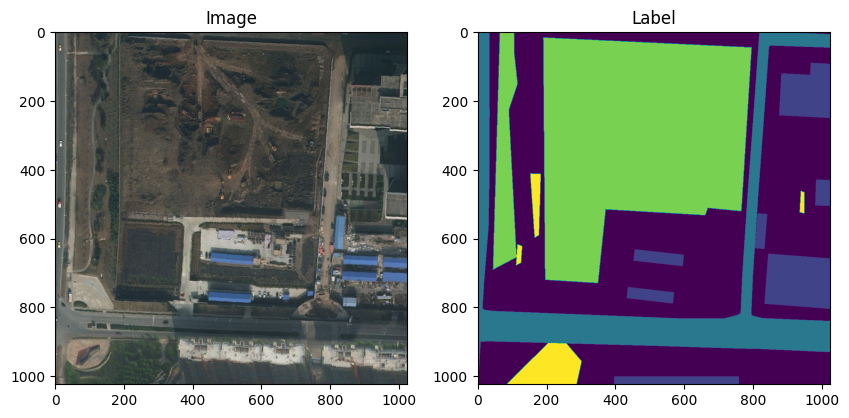

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# Load and visualize an image and its corresponding label
image_path = "Train/Train/Urban/images_png/1366.png"
label_path = "Train/Train/Urban/masks_png/1366.png"

image = Image.open(image_path)
label = Image.open(label_path)

# Display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("Label")
plt.imshow(label)
plt.show()


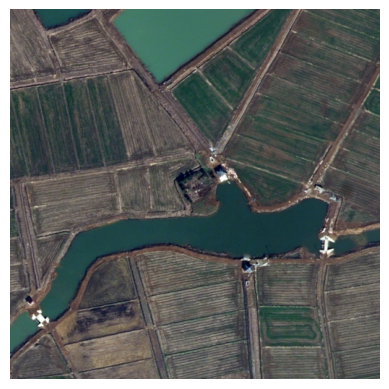

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os




# Example grayscale values
COLOR_MAP = {
    'class1': 0.00392157,
    'class2': 0.00784314,
    'class3': 0.01176471,
    'class4': 0.01568628,
    'class5': 0.01960784,
    'class6': 0.02352941,
    'class7': 0.02745098
}

# Map class names to indices
LABEL_MAP = {k: v for v, k in enumerate(COLOR_MAP.keys())}

# Tolerance-based color to label conversion
def color_to_one_hot(mask, label_map, tolerance=0.001, num_classes=7):
    """
    Converts a grayscale mask to a one-hot encoded mask based on a color map and tolerance.

    Args:
        mask (np.ndarray): The input grayscale mask.
        label_map (dict): A dictionary mapping class names to label indices.
        tolerance (float): The tolerance for matching grayscale values.
        num_classes (int): Number of classes (channels).

    Returns:
        torch.Tensor: The one-hot encoded mask.
    """
    mask = np.asarray(mask, dtype=np.float32)
    one_hot_mask = np.zeros((num_classes, mask.shape[1], mask.shape[2]), dtype=np.float32)

    for class_name, class_index in label_map.items():
        color_value = COLOR_MAP[class_name]
        # Match pixels with the grayscale value within the tolerance
        matches = np.abs(mask - color_value) < tolerance
        # print(class_index, np.squeeze(matches, axis=0))
        one_hot_mask[class_index, np.squeeze(matches, axis=0)] = 1.0

    return torch.from_numpy(one_hot_mask)

# Define a function to denormalize the image
def denormalize(tensor, mean, std):
    """ Denormalize the tensor back to the [0, 1] range for visualization. """
    for i in range(len(mean)):
        tensor[i] = tensor[i] * std[i] + mean[i]
    return tensor

def show_image(image_tensor):
    """ Display a transformed image using matplotlib. """
    image_tensor = denormalize(image_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Denormalize the image
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert to HxWxC format
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

def show_mask(mask_tensor, num_classes=2):
    """ Display the mask using matplotlib. """
    # Convert the mask to a numpy array and display as a 2D image
    mask = mask_tensor.squeeze().cpu().numpy()  # Remove the batch dimension and convert to numpy
    plt.imshow(mask)  # Use a colormap suitable for categorical data
    plt.colorbar()  # Optionally add a color bar
    plt.axis('off')  # Hide axes
    plt.show()


class LoveDADataset(Dataset):
    def __init__(self, root_dir, split='train', transform_image=None, transform_label=None):
        self.root_dir = root_dir
        self.split = split
        self.transform_image = transform_image
        self.transform_label = transform_label

        # Image and Label paths
        self.image_paths = []
        self.label_paths = []

        for subdir in ['Urban', 'Rural']:  # Handling both 'Urban' and 'Rural'
            image_dir = os.path.join(root_dir, split, subdir, 'images_png')
            label_dir = os.path.join(root_dir, split, subdir, 'masks_png')

            for f in os.listdir(image_dir):
                if f.endswith('.png'):  # Assuming the files are PNG images
                    self.image_paths.append(os.path.join(image_dir, f))
                    self.label_paths.append(os.path.join(label_dir, f))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        label = Image.open(self.label_paths[idx])

        if self.transform_image:
            image = self.transform_image(image)

        if self.transform_label:
            label = self.transform_label(label)

        return image, label

# Define transformations
transform_image = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize images to 512x512
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


transform_label = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Lambda(lambda mask: color_to_one_hot(mask, LABEL_MAP)),
])

# Create dataset and dataloader
train_dataset = LoveDADataset(root_dir='Train/', split='Train', transform_image=transform_image, transform_label=transform_label)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

val_dataset = LoveDADataset(root_dir='Val/', split='Val', transform_image=transform_image, transform_label=transform_label)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)


# # Definisci una dimensione più piccola per il subset (ad esempio 10% del dataset)
# subset_size = 100  # Usa solo i primi 100 campioni per il test

# # Usa torch.utils.data.Subset per ottenere un subset casuale dei dati
# subset_indices = torch.randperm(len(train_loader.dataset)).tolist()[:subset_size]
# train_subset = torch.utils.data.Subset(train_loader.dataset, subset_indices)

# # Crea un DataLoader per il subset
# #DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)
# train_subset_loader = DataLoader(train_subset, batch_size=2, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)
# for i, (image, label) in enumerate(train_subset_loader):
#     if i == 0:  # Show only the first batch
#         show_image(image[0])  # Access the first image of the batch
#         show_mask(label[0])
#         break


# Visualize the first batch of images
for i, (image, label) in enumerate(train_loader):
    if i == 0:  # Show only the first batch
        show_image(image[0])  # Access the first image of the batch
        #show_mask(label[0])
        break




In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
!pip install thop
from thop import profile, clever_format #used at the end
import os

import numpy as np

In [7]:
!git clone https://github.com/XuJiacong/PIDNet.git



Cloning into 'PIDNet'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 386 (delta 131), reused 125 (delta 125), pack-reused 193 (from 1)
Receiving objects: 100% (386/386), 212.80 MiB | 19.37 MiB/s, done.
Resolving deltas: 100% (184/184), done.
Updating files: 100% (73/73), done.


In [8]:
!pip install torch torchvision thop opencv-python tqdm numpy scipy #manually install the necessary libraries:
%cd content

[Errno 2] No such file or directory: 'content'
/content


In [9]:
import sys
sys.path.append('/content/PIDNet') #è utile se si ha un modulo che non è installato nelle cartelle di ricerca predefinite di Python, ma si trova in una cartella personalizzata o diversa. la directory /content/PIDNet è aggiunta alla lista di ricerca, in modo che Python possa importare moduli da questa cartella.

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from models.model_utils import BasicBlock, Bottleneck, segmenthead, DAPPM, PAPPM, PagFM, Bag, Light_Bag
import logging
# from models.pidnet import get_pred_model
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_


def get_seg_model(name, num_classes, imgnet_pretrained, model_pth):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=True)



    if imgnet_pretrained:
        print("vamos")
        pretrained_state = torch.load(model_pth, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        print(len(pretrained_state))
        print(len(model_dict))
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        print('Attention!!!')
        print(msg)
        print('Over!!!')
        model.load_state_dict(model_dict, strict = False)
        print("done")
    else:
        # print("vamos")

        pretrained_dict = torch.load(model_pth, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_seg_model(name='pidnet_s', num_classes=7, imgnet_pretrained=True, model_pth='PIDNet_S_ImageNet.pth.tar').to(device)




vamos
302
479
Attention!!!
Loaded 302 parameters!
Over!!!
done


<ipython-input-30-bc2d857a7031>:195: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(model_pth, map_location='cpu')['state_dict']


In [31]:
num_classes=7
# mIoU calculation function
def compute_mIoU(preds, labels, num_classes):
    intersection = torch.zeros(num_classes).to(device)
    union = torch.zeros(num_classes).to(device)

    preds = preds.argmax(dim=1)  # Get the class with the highest score for each pixel
    for i in range(num_classes):
        intersection[i] = torch.sum((preds == i) & (labels == i)).float()
        union[i] = torch.sum((preds == i) | (labels == i)).float()

    IoU = intersection / (union + 1e-6)
    mIoU = IoU.mean()
    return mIoU


In [35]:
import torch.nn.functional as F
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        images, masks = images.to(device), masks.to(device)

        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        outputs = model(images) # is a list of tensors


        #print(f"Number of outputs in the list: {len(outputs)}")
         #Print the shape of each element in the list
        #for i, output in enumerate(outputs):
         #   print(f"Output {i} shape: {output.shape}")

        # Assuming x_ is the main output
        main_output = outputs[1]  # Get the main output (second element)


        # Upsample the main output to match the target resolution (512x512)
        main_output = F.interpolate(main_output, size=(masks.shape[2], masks.shape[3]), mode='bilinear', align_corners=False)

        # Ensure masks are in the right shape and type (long)
        masks = masks.squeeze(1)  # Remove extra channel dimension and convert to long

        # Calculate loss
        loss = criterion(main_output, masks)  # Use the main output for loss calculation
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{epochs}] Training Loss: {avg_loss:.4f}")

    # Clear GPU memory
    torch.cuda.empty_cache()

    # VALIDATION phase
    model.eval()
    val_loss = 0.0
    intersection = torch.zeros(num_classes).to(device)
    union = torch.zeros(num_classes).to(device)

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)


            # Get the main output and upsample it to match the target resolution
            main_output = outputs[1]  # Assuming x_ is the second element in the list
            main_output = F.interpolate(main_output, size=(masks.shape[2], masks.shape[3]), mode='bilinear', align_corners=False) #mask.shape -> torch.Size([2, 7, 512, 512])

            # Ensure masks are in the right shape and type (long)
            masks = masks.squeeze(1)

            # Calculate loss
            loss = criterion(main_output, masks)
            val_loss += loss.item()

            # Calculate mIoU incrementally
            preds = main_output.argmax(dim=1).detach()  # Detach to prevent GPU memory buildup
            masks = masks.argmax(dim=1).detach()
            for i in range(num_classes):
                intersection[i] += torch.sum((preds == i) & (masks == i)).float()
                union[i] += torch.sum((preds == i) | (masks == i)).float()

            # Free GPU memory
            del outputs, preds, masks
            torch.cuda.empty_cache()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Calculate mIoU
    IoU = intersection / (union + 1e-6)  # Avoid division by zero
    mIoU = IoU.mean()
    print(f"Validation mIoU: {mIoU:.4f}")


Epoch 1/20: 100%|██████████| 1261/1261 [05:08<00:00,  4.08it/s]


Epoch [1/20] Training Loss: 1.3576


Validation: 100%|██████████| 835/835 [02:46<00:00,  5.02it/s]


Validation Loss: 1.5429
Validation mIoU: 0.2320


Epoch 2/20: 100%|██████████| 1261/1261 [05:07<00:00,  4.10it/s]


Epoch [2/20] Training Loss: 1.1771


Validation: 100%|██████████| 835/835 [02:43<00:00,  5.11it/s]


Validation Loss: 1.5912
Validation mIoU: 0.2194


Epoch 3/20: 100%|██████████| 1261/1261 [05:01<00:00,  4.18it/s]


Epoch [3/20] Training Loss: 1.0730


Validation: 100%|██████████| 835/835 [02:38<00:00,  5.27it/s]


Validation Loss: 3.6958
Validation mIoU: 0.1177


Epoch 4/20: 100%|██████████| 1261/1261 [05:00<00:00,  4.20it/s]


Epoch [4/20] Training Loss: 1.0237


Validation: 100%|██████████| 835/835 [02:45<00:00,  5.05it/s]


Validation Loss: 1.5439
Validation mIoU: 0.2761


Epoch 5/20: 100%|██████████| 1261/1261 [04:59<00:00,  4.21it/s]


Epoch [5/20] Training Loss: 0.9859


Validation: 100%|██████████| 835/835 [02:38<00:00,  5.28it/s]


Validation Loss: 1.4714
Validation mIoU: 0.2910


Epoch 6/20: 100%|██████████| 1261/1261 [04:57<00:00,  4.24it/s]


Epoch [6/20] Training Loss: 0.9971


Validation: 100%|██████████| 835/835 [02:38<00:00,  5.28it/s]


Validation Loss: 1.1603
Validation mIoU: 0.3128


Epoch 7/20: 100%|██████████| 1261/1261 [04:55<00:00,  4.27it/s]


Epoch [7/20] Training Loss: 0.9375


Validation: 100%|██████████| 835/835 [02:38<00:00,  5.26it/s]


Validation Loss: 1.7632
Validation mIoU: 0.2802


Epoch 8/20: 100%|██████████| 1261/1261 [04:57<00:00,  4.23it/s]


Epoch [8/20] Training Loss: 0.9026


Validation: 100%|██████████| 835/835 [02:38<00:00,  5.28it/s]


Validation Loss: 1.6380
Validation mIoU: 0.2898


Epoch 9/20: 100%|██████████| 1261/1261 [04:59<00:00,  4.21it/s]


Epoch [9/20] Training Loss: 0.8777


Validation: 100%|██████████| 835/835 [02:38<00:00,  5.25it/s]


Validation Loss: 2.1901
Validation mIoU: 0.3078


Epoch 10/20: 100%|██████████| 1261/1261 [05:01<00:00,  4.18it/s]


Epoch [10/20] Training Loss: 0.8930


Validation: 100%|██████████| 835/835 [02:36<00:00,  5.35it/s]


Validation Loss: 1.7140
Validation mIoU: 0.3166


Epoch 11/20: 100%|██████████| 1261/1261 [04:58<00:00,  4.22it/s]


Epoch [11/20] Training Loss: 0.8654


Validation: 100%|██████████| 835/835 [02:38<00:00,  5.28it/s]


Validation Loss: 1.2264
Validation mIoU: 0.3329


Epoch 12/20: 100%|██████████| 1261/1261 [04:59<00:00,  4.21it/s]


Epoch [12/20] Training Loss: 0.8504


Validation: 100%|██████████| 835/835 [02:38<00:00,  5.25it/s]


Validation Loss: 1.2308
Validation mIoU: 0.3149


Epoch 13/20: 100%|██████████| 1261/1261 [05:01<00:00,  4.18it/s]


Epoch [13/20] Training Loss: 0.8207


Validation: 100%|██████████| 835/835 [02:40<00:00,  5.19it/s]


Validation Loss: 1.5558
Validation mIoU: 0.3082


Epoch 14/20: 100%|██████████| 1261/1261 [04:59<00:00,  4.21it/s]


Epoch [14/20] Training Loss: 0.8116


Validation: 100%|██████████| 835/835 [02:38<00:00,  5.27it/s]


Validation Loss: 1.9477
Validation mIoU: 0.3095


Epoch 15/20: 100%|██████████| 1261/1261 [04:57<00:00,  4.23it/s]


Epoch [15/20] Training Loss: 0.8082


Validation: 100%|██████████| 835/835 [02:38<00:00,  5.27it/s]


Validation Loss: 1.2505
Validation mIoU: 0.3415


Epoch 16/20: 100%|██████████| 1261/1261 [04:58<00:00,  4.23it/s]


Epoch [16/20] Training Loss: 0.7886


Validation: 100%|██████████| 835/835 [02:37<00:00,  5.29it/s]


Validation Loss: 3.0489
Validation mIoU: 0.2937


Epoch 17/20: 100%|██████████| 1261/1261 [04:58<00:00,  4.23it/s]


Epoch [17/20] Training Loss: 0.8005


Validation: 100%|██████████| 835/835 [02:39<00:00,  5.22it/s]


Validation Loss: 1.5645
Validation mIoU: 0.3247


Epoch 18/20: 100%|██████████| 1261/1261 [05:00<00:00,  4.20it/s]


Epoch [18/20] Training Loss: 0.7739


Validation: 100%|██████████| 835/835 [02:41<00:00,  5.16it/s]


Validation Loss: 1.4086
Validation mIoU: 0.3375


Epoch 19/20: 100%|██████████| 1261/1261 [04:59<00:00,  4.22it/s]


Epoch [19/20] Training Loss: 0.7763


Validation: 100%|██████████| 835/835 [02:38<00:00,  5.26it/s]


Validation Loss: 1.9485
Validation mIoU: 0.3043


Epoch 20/20: 100%|██████████| 1261/1261 [04:57<00:00,  4.23it/s]


Epoch [20/20] Training Loss: 0.7756


Validation: 100%|██████████| 835/835 [02:37<00:00,  5.29it/s]

Validation Loss: 1.6549
Validation mIoU: 0.3590


In [36]:
import time
# Performance Evaluation (Latency, FLOPs, and Parameters)
print("\nEvaluating Model Performance:")

# Measure latency
dummy_input = torch.randn(1, 3, 512, 512).to(device)
model.eval()
with torch.no_grad():
    start_time = time.time()
    model(dummy_input)
    end_time = time.time()
latency = (end_time - start_time) * 1000  # Convert to milliseconds
print(f"Latency: {latency:.2f} ms")

# Compute FLOPs and Params
flops, params = profile(model, inputs=(dummy_input,), verbose=False)
flops, params = clever_format([flops, params], "%.3f")
print(f"FLOPs: {flops}")
print(f"Params: {params}")

# Optionally, print class-wise IoU
print("\nClass-wise IoU:")
IoU = intersection / (union + 1e-6)
for i, iou in enumerate(IoU):
    print(f"Class {i+1} IoU: {iou:.4f}")



Evaluating Model Performance:
Latency: 17.43 ms
FLOPs: 6.346G
Params: 7.718M

Class-wise IoU:
Class 1 IoU: 0.4748
Class 2 IoU: 0.3584
Class 3 IoU: 0.3346
Class 4 IoU: 0.4334
Class 5 IoU: 0.1584
Class 6 IoU: 0.3313
Class 7 IoU: 0.4223
